Corpus Analytics
==============

Now that we've overviewed all the steps involved in preparing text for computational analysis, we can begin the 
work of analysis proper. Whereas the last chapter suggested a few ways we might do this with a single novel, this 
one will build out to a whole collection of texts, or a **corpus**. Computational analysis can help us discover 
many interesting things about a single text, but looking at this text in the context of many others will do much to 
clarify and expand any potential findings we might make. Accordingly, we'll learn how to implement our cleaning 
steps on multiple files and then format them in a way that enables us to make connections between them. We'll then 
generate several metrics about these texts and use them to observe similarities/differences across the corpus.

We'll also leave _Frankenstein_ behind, at least for now. In place of this novel, we will use Andrew Piper's 
[collection of English short stories](https://doi.org/10.6084/m9.figshare.17425571.v1), which gathers together 50 
stories from 1981 to 2006. **UNCLEAR WHETHER WE'LL ULTIMATELY USE THIS ONE---PLUGGING IT IN TO OUTLINE THE 
CHAPTER.**

```{admonition} Learning Objectives
By the end of this workshop, you will be able to:

+ Develop a workflow for cleaning multiple texts and compiling them into a corpus
+ Use a document-term matrix, to represent relationships between texts in a corpus
+ Generate metrics about texts in a corpus, including document length, term frequency, lexical diversity, etc.
+ Explain the difference between raw term metrics and weighted term scoring (specifically, TF-IDF scoring)
+ Cluster texts according to their shared/similar features
```

The Data
-----------

Before we begin cleaning, let's load in a file manifest to get a quick overview of what will be in our corpus. 
We'll also use this manifest to sequentially load each file, clean it, and add it to our corpus.

Number of stories: 50 
Number of authors: 50 
Columns in the manifest: ['NAME' 'YEAR' 'FILE_NAME']


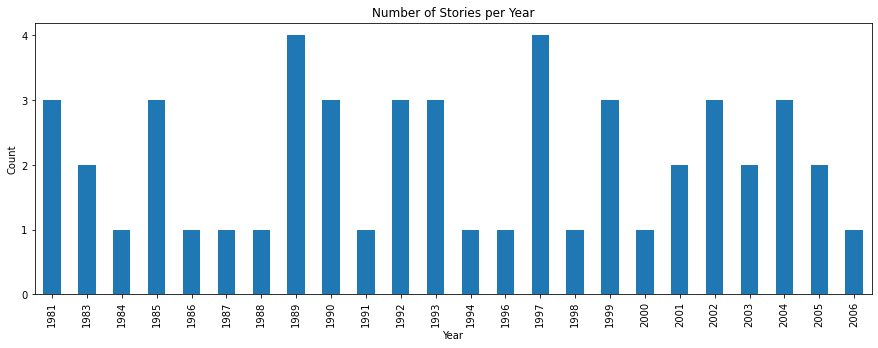

In [1]:
import pandas as pd

indir =  "data/session_two/"
manifest = pd.read_csv(indir + "manifest.csv", index_col = 0)
manifest = manifest.set_index('TITLE')

print(
    "Number of stories:", len(manifest),
    "\nNumber of authors:", manifest['NAME'].nunique(),
    "\nColumns in the manifest:", manifest.columns.values
)
manifest.groupby('YEAR')['NAME'].count().plot.bar(figsize = (15, 5),
                                                  title = "Number of Stories per Year",
                                                  xlabel = "Year",
                                                  ylabel = "Count",
                                                  yticks = range(0, 5)
                                                 );

Here are a few story titles, selected at random:

In [2]:
for title in manifest.sample(5).index:
    print(f"{manifest.loc[title, 'NAME']}:", title)

MINOT, Susan: Lust
GILB, DAGOBERTO: WinnersonthePassLine
NELSON, Antonya: FemaleTrouble
DYBEK, Stuart: WeDidn’t
SONTAG, Susan: TheWayWeLiveNow


```{tip}
Using a metadata sheet like this is a good habit to develop. Use it as a common reference point for any processes 
you run on your data, and you'll mitigate major headaches stemming from undocumented projects. For more about this, 
see the DataLab's [workshop on project organization and data documentation][].

[workshop on project organization and data documentation]: https://ucdavisdatalab.github.io/workshop_how-to-data-documentation/
```

Text Cleaning
----------------

### Recap

With our manifest loaded, we can review our cleaning steps. For each short story in our corpus, we want to:

1. Resolve casing
2. Remove punctuation, numbers, and any extra formatting
3. Remove stop words

This should feel familiar, though our workflow here will differ slightly from the one in the last chapter because 
we'll be cleaning multiple texts, not only one. All the principles remain the same, we just want to implement our 
cleaning steps in a way that successively works through every text in our data directory without much intervention 
on our part. This is where functions are helpful; we'll define a series of them, with each performing a separate 
step in the cleaning process. We'll also define a main function, `clean()`, which we'll use to control the various 
cleaning steps. That way we can simply load in a text file and pass it to `clean()` and `clean()` will handle the 
rest.

Note that our steps do not include lemmatizing the texts. Because lemmatization can be labor- and time-intensive, 
**these texts have already been processed with `nltk`'s lemmatizer**.

### Text cleaning functions

`clean()` will call the following five functions:

1. `to_lower()`: returns a lowercase version of all tokens in a text
2. `remove_punctuation()`: removes all punctuation in phases: hyphens, em dashes, and underscores first, then 
everything else
3. `remove_digits()`: removes digits
4. `remove_whitespace()`: removes any extra whitespace
5. `remove_stop_words()`: filters out stop words from the list of tokens; we'll also remove any words that are two 
or less characters long

Let's get coding!

In [3]:
import re

with open("data/voyant_stoplist.txt", 'r') as f:
    stopwords = f.read().split()

def to_lower(doc):
    return doc.lower()

def remove_punctuation(doc):
    doc = re.sub(r"[-]|[—]|[_]", " ", doc)
    doc = re.sub(r"[^\w\s]", "", doc)
    return doc

def remove_digits(doc):
    return re.sub(r"[0-9]", "", doc)

def remove_whitespace(doc):
    doc = re.sub(r"\s+", " ", doc)
    return doc

def remove_stop_words(doc):
    doc = doc.split()
    doc = [token for token in doc if token not in stopwords]
    doc = [token for token in doc if len(token) > 2]
    doc = ' '.join(doc)
    return doc

def clean(doc):
    lowercase = to_lower(doc)
    no_punct = remove_punctuation(lowercase)
    no_digits = remove_digits(no_punct)
    no_whitespace = remove_whitespace(no_digits)
    stopped = remove_stop_words(no_whitespace)
    return stopped

```{admonition} About the above...
These functions are written with **clarity** and **modularity** in mind. The intent here is to demonstrate each 
step of the cleaning process in as discrete a manner as possible. But you might find that some of this code is 
redundant (as an example, ask yourself: which step might be wrapped up inside another function?). Further, we could 
very probably re-factor this code to optimize it, which would be important when working with a large number of 
texts. We won't cover something like that in this session, however. For now, know that these functions are meant to 
act as templates, which you can modify to suit your own needs.
```

### Cleaning our texts

With our functions defined, we can now load each story, roll through all the cleaning steps, and append the cleaned 
story to a list. The result will be our **corpus**, a fifty-item list of strings, where each string contains all 
the tokens in a given story. The _order_ of these entries will be important for work we want to do later on, so we 
need to make sure that each string always has the same position in the larger list of stories. This is where the 
file manifest comes in: _we'll load stories in the order provided by the `FILE_NAME` column of `manifest`_. Doing 
so ensures that the first index (`0`) of our corpus corresponds to the first short story, the second index (`1`) to 
the second, and so on.


Let's write all this out in a `for` loop and do our cleaning.

```{margin} What this loop does:
1. For every row (`idx`) in `manifest`, collect the item in the row's `FILE_NAME` column and append it to `indir`
2. Put the resultant filepath in a `with...open` statement to read in a file
3. Clean the story with `clean()`
4. Append the result to `corpus`
```

In [4]:
corpus = []

for title in manifest.index:
    filepath = indir + manifest.loc[title, 'FILE_NAME']
    with open(filepath, 'r') as f:
        story = f.read()
        cleaned_story = clean(story)
        corpus.append(cleaned_story)

As a sanity check, we can run an assertion statement, which checks that `corpus` has as many stories in it as 
`manifest` does...

```{margin} On assertions...
If the lengths of `corpus` and `manifest` didn't match, `assert` would throw an `AssertionError` with the message 
after the comma.
```

In [5]:
assert len(corpus) == len(manifest), "Lengths don't match!"

...and we can inspect some tokens from a few stories to make sure all is well:

In [6]:
for idx in [4, 17, 39]:
    fragment = corpus[idx].split()
    print(' '.join(fragment[10:20]))

behind card table outside food minute sun shift chair table
barbie away ken practice future sit sisters room watch barbie
silver cloud float horizon robin sparrow trees son joshuas seventh


Looks great!

The Document-Term Matrix
--------------------------------

Before we switch into full data exploration mode, we're going to perform one last process on our corpus. Remember 
from the last chapter that much of text analytics relies on **counts** and **context**: tracking the former in 
tandem with the latter is how we identify relationships between words (the final section on bigram PMI scores 
demonstrated this, for example). As with _Frankenstein_, here we'll want to tally up all the words in each story. 
That produces one kind of text---or rather, fifty different contexts: one for every story. But we have at our hands 
a _corpus_, the analysis of which requires a different kind of context: a single one for all the stories. That is, 
we need a way to relate stories _to each other_, instead of only tracking word values across single texts.

To do so, we'll build a **document-term matrix**, or **DTM**. A DTM is a matrix that contains the frequencies of 
terms in a corpus. Every row in this matrix corresponds to a document, while every column corresponds to a term. 
For a given document, we count the number of times that term appears and enter that number in the column in 
question. We do this _even if_ the count is 0; key to the way a DTM works is that it represents corpus-wide 
relationships between texts, so it matters if a text does or doesn't contain a term.

Here's a toy example. Imagine three documents:

1. "I like cats. Do you?"
2. "I only like dogs. And you?"
3. "I like cats and dogs."

Transforming these into a document-term matrix would yield:

In [7]:
example_corpus = [[1, 0, 1, 1, 0, 0, 1, 1],
                  [1, 1, 1, 0, 1, 1, 0, 1],
                  [1, 0, 1, 1, 1, 1, 0, 0]]

example_dtm = pd.DataFrame(example_corpus, 
                           index = ['D1', 'D2', 'D3'], 
                           columns = ['i', 'only', 'like', 'cats', 'and', 'dogs', 'do', 'you']
                          )

example_dtm

,i,only,like,cats,and,dogs,do,you
D1,1,0,1,1,0,0,1,1
D2,1,1,1,0,1,1,0,1
D3,1,0,1,1,1,1,0,0


Representing texts in this way is incredibly useful because it enables us to easily (and programmatically) discern 
similarities and differences in our corpus. For example, we can see that each of the above documents contains the 
words "I" and "like." Given that, if we wanted to know what makes each document unique, we could ignore those two 
words and focus on the rest of the values.

Now, imagine doing this for thousands of words. What patterns might emerge?

The `scikit-learn` library makes generating a DTM very easy. All we need to do is import a `CountVectorizer()` 
object, initialize it by assigning it to a variable, and fit it to our corpus. This will result in two things: 1) a 
fitted `CountVectorizer()`, which will contain a series of different attributes that are useful for corpus 
exploration; 2) a vectorized representation of our corpus, the document-term matrix.

```{margin} More on this
`CountVectorizer()` accepts several different arguments that will modify its base functionality, including 
arguments for applying some text cleaning steps. We won't use any of these arguments because we've already cleaned 
our text (and indeed it's a good idea to clean your text yourself so you always know what processes have been run 
on it), but you can learn more about them [here].

[here]: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
```

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
vectorized_corpus = count_vectorizer.fit_transform(corpus)

print(
    f"Shape of our document-term matrix: {vectorized_corpus.shape},", 
    f"or {vectorized_corpus.shape[0]} documents (rows)", 
    f"and {vectorized_corpus.shape[1]} words (columns)"
)

Shape of our document-term matrix: (50, 15962), or 50 documents (rows) and 15962 words (columns)


`CountVectorizer()` returns a **sparse matrix**, or a matrix comprised mostly of zeros. This matrix has been 
formatted to be highly memory efficient, which is useful when dealing with giant datasets, but it's not very 
accessible for data exploration. Since our corpus is relatively small, we'll convert this sparse matrix into a 
`Pandas` dataframe. Note all the zeros!

In [9]:
dtm = pd.DataFrame(vectorized_corpus.toarray())
dtm.iloc[:5,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,9,0,0


As it stands, this dataframe is hard to understand. But luckily, we've kept track of which row corresponds to which 
story: this is why we used our manifest to control our file order. Further, the fitted `CountVectorizer()` has a 
special method, `get_feature_names_out()`, which will generate an array of all the tokens from all the files (our 
vocabulary). The order of this array corresponds to the order of our columns. Accordingly, we can assign this array 
to the column names of `dtm` and assign the story titles in `manifest` to its index names, making it much easier to 
associate column values with row values.

In [10]:
dtm.columns = count_vectorizer.get_feature_names_out()
dtm.index = manifest.index
dtm.iloc[:5,:15]

,aaa,aaaaargh,aaaargh,aachen,aachens,aahed,aback,abandon,abandoned,abbey,abbreviate,abby,abbylucyferny,abdomen,abdominal
TITLE,,,,,,,,,,,,,,,
TheSchool,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tony’sStory,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NineteenFifty-five,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Girl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Territory,0,0,0,0,0,0,0,0,0,0,0,1,9,0,0


Term Metrics
---------------

With our DTM made, we can use it to generate some metrics about each text in our corpus. We'll use `Pandas` data 
manipulations in conjunction with `NumPy` to do this.

### Raw Metrics

Here's an easy one: let's count the number of tokens in each story and assign the result to a new column in our 
manifest.

```{margin} Vectorized functions
If you're unfamiliar with `apply()`, or it's just been a while since you've used it, this method applies a function 
along an axis of a dataframe. Think of it like a shorthand for a `for` loop: the default usage runs every column 
through your desired function. In this case, we're setting the `axis` to `1` so `sum()` runs on every row. This 
will sum together each value in every row.
```

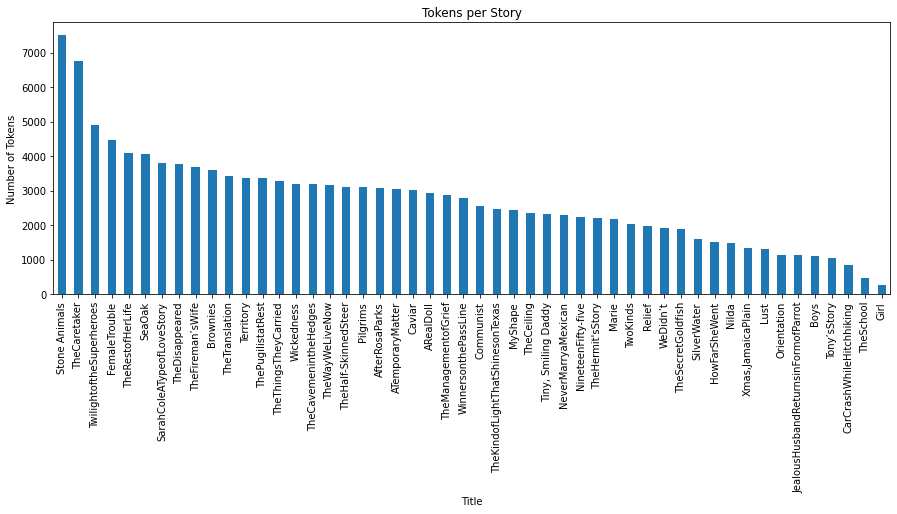

In [11]:
import numpy as np

manifest = manifest.assign(NUM_TOKENS = dtm.apply(sum, axis = 1).values)

manifest['NUM_TOKENS'].sort_values(ascending=False).plot.bar(figsize = (15, 5),
                                                             title = "Tokens per Story",
                                                             xlabel = 'Title',
                                                             ylabel = 'Number of Tokens'
                                                            );

We can also count the number of unique words, or **types**, in each story. Types correspond to a story's 
vocabulary, whereas tokens correspond to the amount of elements in a story.

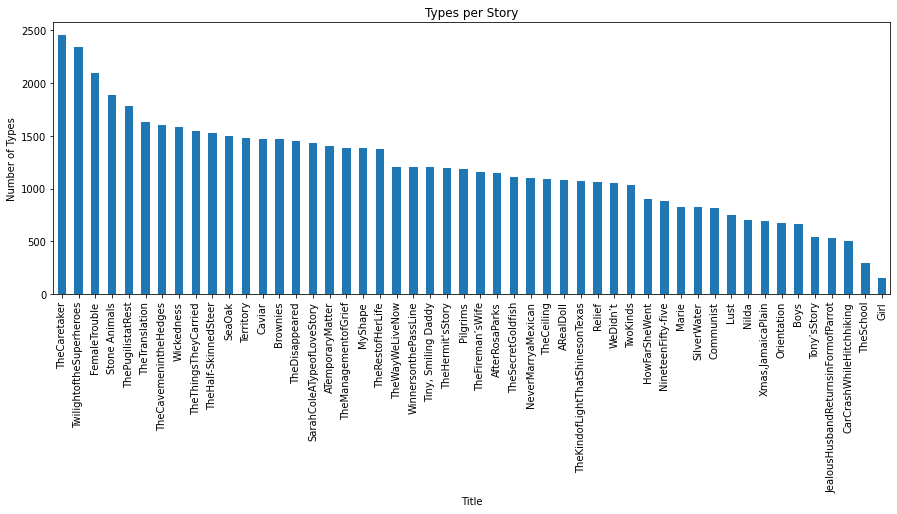

In [12]:
manifest = manifest.assign(NUM_TYPES = dtm.apply(np.count_nonzero, axis = 1))

manifest['NUM_TYPES'].sort_values(ascending = False).plot.bar(figsize = (15, 5),
                                                              title = "Types per Story",
                                                              xlabel = 'Title',
                                                              ylabel = 'Number of Types'
                                                             );

With tokens and types generated, we can generate a measure of **lexical diversity**. There are a few such measures. 
We'll go with a **type-token ratio** (TTR), which measures how much the vocabulary of a text varies over its 
tokens. It's a simple metric: divide the number of types (unique words) by the total number of tokens in a text and 
normalize the result. A text with a TTR of 100, for example, would never repeat a word.

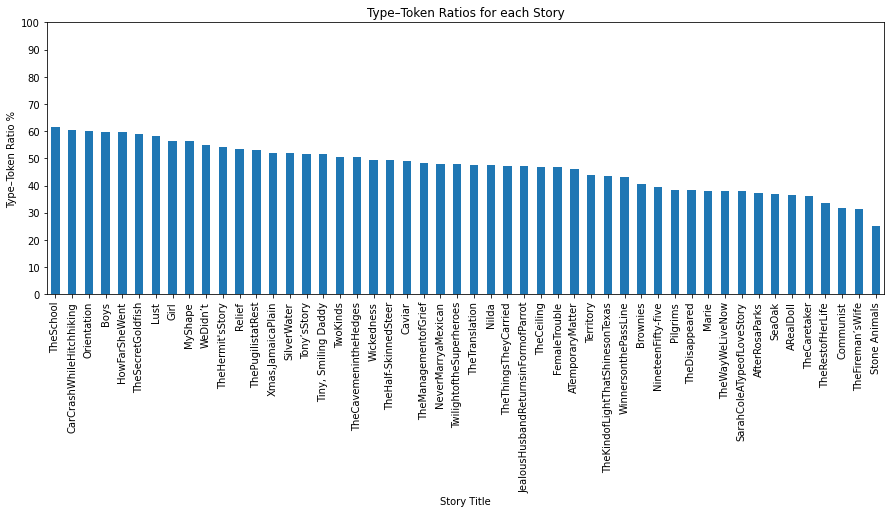

In [13]:
manifest = manifest.assign(TTR = (manifest['NUM_TYPES'] / manifest['NUM_TOKENS']) * 100)

manifest['TTR'].sort_values(ascending = False).plot.bar(figsize = (15, 5),
                                                        title = 'Type–Token Ratios for each Story',
                                                        legend = None,
                                                        xlabel = 'Story Title',
                                                        ylabel = 'Type–Token Ratio %',
                                                        yticks = range(0, 110, 10)
                                                       );

Let's move to terms. Here are the top five most occurring terms in the corpus:

In [14]:
dtm.sum().sort_values(ascending = False).head(5)

say     2028
like    1495
know    1031
look     953
said     867
dtype: int64

And here are the bottom five:

In [15]:
dtm.sum().sort_values().head(5)

aaa              1
heartbroken      1
heartbreaking    1
heartbreak       1
heartache        1
dtype: int64

Though there are likely to be quite a few one-count terms. Here are the bottom ten:

In [16]:
dtm.sum().sort_values().head(10)

aaa              1
heartbroken      1
heartbreaking    1
heartbreak       1
heartache        1
hearse           1
hears            1
signature        1
significance     1
significant      1
dtype: int64

Each of these terms is called a **hapax legomenon** (Greek for "only said once"). How many are in our corpus 
altogether?

In [17]:
hapaxes = dtm.sum()[dtm.sum() == 1]

print(
    f"Number of hapax legomenons: {len(hapaxes)},",
    f"or {len(hapaxes) / len(dtm.T):.02f}% of the words in our corpus"
)

Number of hapax legomenons: 7463, or 0.47% of the words in our corpus


How many terms are in the top five quantiles of the term counts?

In [18]:
count_quantile = dtm.sum().quantile(0.95)
count_quantile_words = dtm.sum()[dtm.sum() >= count_quantile]

print(
    f"Word counts for the ninety-fifth quantile: {count_quantile}",
    f"\nNumber of words with counts at or above this quantile: {len(count_quantile_words)}", 
    f"({len(count_quantile_words) / len(dtm.T):.02f}% of words)"
)

Word counts for the ninety-fifth quantile: 31.0 
Number of words with counts at or above this quantile: 801 (0.05% of words)


The discrepancies between the above two values should feel familiar: our term distribution is Zipfian.

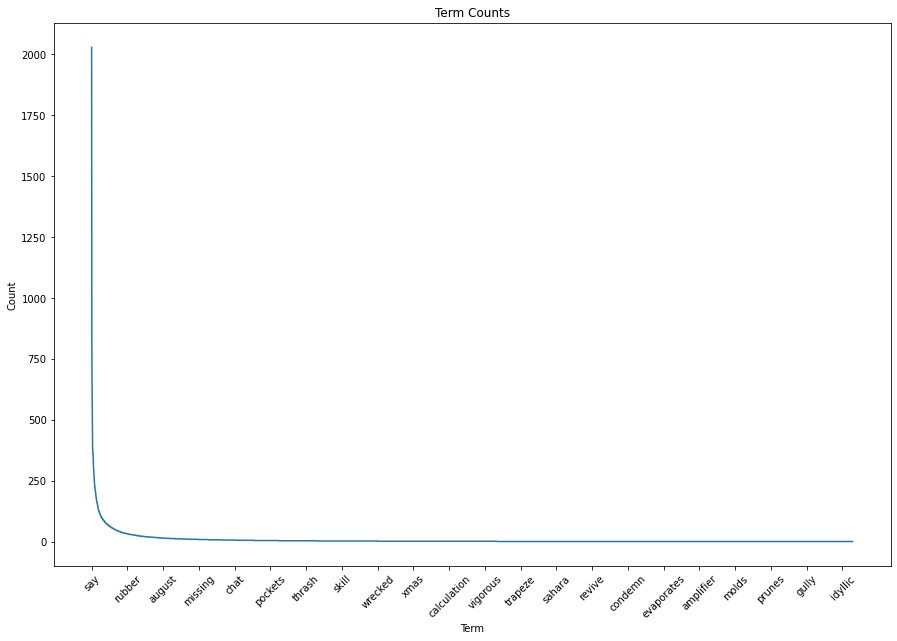

In [19]:
dtm.sum().sort_values(ascending=False).plot(figsize = (15, 10),
                                            title = 'Term Counts',
                                            xlabel = 'Term', 
                                            ylabel = 'Count',
                                            xticks = range(0, len(dtm.T), 750),
                                            rot = 45
                                           );

This distribution has a few consequences for us. On the one hand, it suggests that we might have some more cleaning 
to do in terms of stop word removal: "say" and "like" could be candidates for removal. If we don't remove these 
terms, we might have trouble identifying unique aspects of each story in our corpus. Highly frequent terms will 
choke out differences across the corpus, as we can see here with the top terms for each story:

In [20]:
dtm.idxmax(axis = 1)

TITLE
TheSchool                                   say
Tony’sStory                                leon
NineteenFifty-five                          say
Girl                                       dont
Territory                                  neil
HowFarSheWent                              girl
SarahColeATypeofLoveStory                   say
Caviar                                    marie
WinnersonthePassLine                        ray
TheWayWeLiveNow                             say
Communist                                  glen
TheManagementofGrief                        say
TheFireman’sWife                           says
Wickedness                                  say
Lust                                       like
TwoKinds                                 mother
TheDisappeared                             said
ARealDoll                                barbie
TheThingsTheyCarried                      carry
NeverMarryaMexican                         like
CarCrashWhileHitchhiking          

In [21]:
top_terms = dtm.idxmax(axis = 1)
target = ['say', 'says', 'said']

print(
    f"Stories where {target} is the top word: {len(top_terms[top_terms.isin(target)])}",
)

Stories where ['say', 'says', 'said'] is the top word: 17


That's a third of our stories!

But there's also an argument to be made for keeping "said" and "say" in our corpus. We are, after all, looking at 
narrative stories, and it matters that there's dialogue. Removing these words would prevent us from studying this 
later on.

How, then, can we have it both ways? How can we reduce the influence of highly frequent terms without removing them 
altogether?

### Weighted Metrics

The answer is to **weight** our terms, doing so in a way that lessens the impact of terms we know to be highly 
general for our corpus and increases the impact of terms that are unique to each story. The most popular way to do 
this is to implement **tf-idf, or term frequency–inverse document frequency, scoring**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.98)
tfidf_vectorized = tfidf_vectorizer.fit_transform(corpus)

tfidf_dtm = pd.DataFrame(tfidf_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=manifest.index)

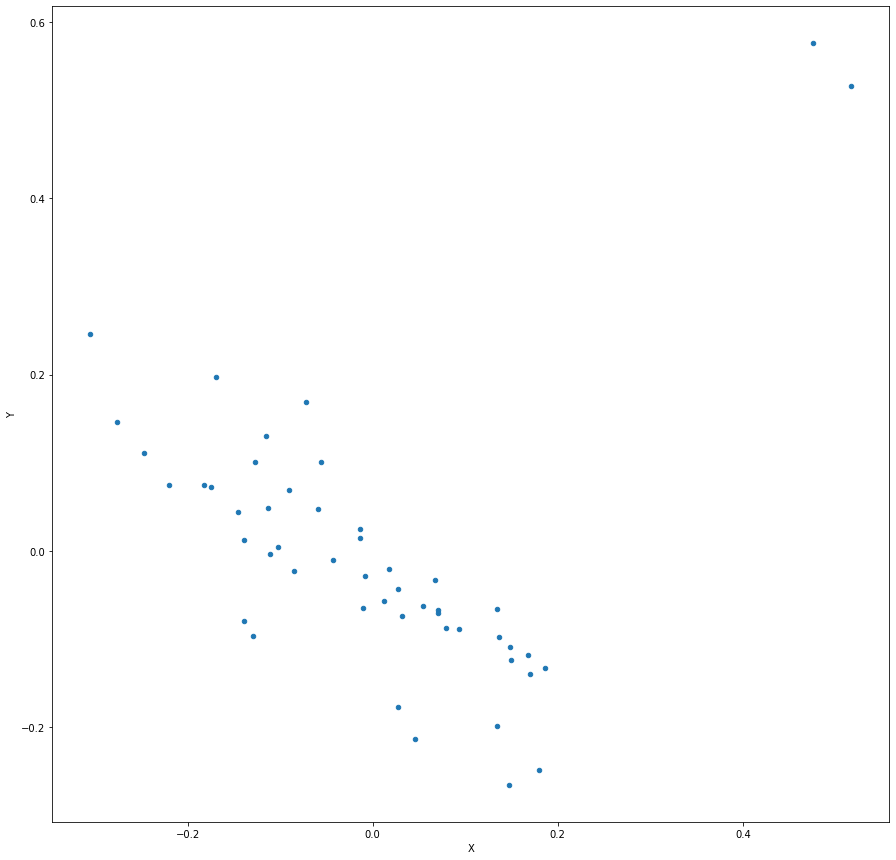

In [23]:
from sklearn.decomposition import PCA

pca = PCA(2).fit_transform(tfidf_dtm)
pd.DataFrame(pca, columns=['X', 'Y']).plot.scatter(figsize=(15, 15), x='X', y='Y');